# Recommendations with IBM

In this notebook, I will be putting my recommendation skills to use on real data from the IBM Watson Studio platform. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

First import the packages, datasets, and perform some data understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import math

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df.shape#shape of the dataset

(45993, 3)

In [3]:
df['email'].isnull().sum()#Number of NANs in the email column/invalid interactions

17

In [4]:
df['title'].isnull().sum()#Number of nans in the title column

0

In [5]:
df['article_id'].isnull().sum()#Number of nans in the article-id column

0

In [6]:
df1 = df[~df['email'].isnull()]#Remove the null contents

In [7]:
df1.shape#shape of the new dataset with null elements removed

(45976, 3)

In [8]:
users = df1['email'].unique()#Users -number of unique users
len(users)

5148

In [9]:
df1.duplicated(['email','title']).sum()#how many duplicated articles/user interactions

12307

In [10]:
df1.duplicated(['title']).sum()#how many duplicated articles

45262

In [11]:
df1.duplicated(['article_id']).sum()#how many duplicated articles

45262

In [11]:
df1.duplicated(['email']).sum()#how many duplicated articles

40828

In [12]:
len(df['article_id'].unique())#Total Nuber of articles reviewed

714

#### Explore and remove duplicate articles from the **df_content** dataframe. 

In [13]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [14]:
df_content['article_id'].duplicated().sum()#how many duplicated articles

5

In [15]:
df_content.shape#Shape of dataset

(1056, 5)

In [16]:
df_content1 = df_content[~df_content['article_id'].duplicated()]#Remove duplicated articles

In [17]:
df_content1.shape

(1051, 5)

In [18]:
df_content['article_id'].nunique()

1051

Interestingly, there are more article id's on this content dataframe than were involved in interacting with the users

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [19]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


#### Visualize the distribution of interactions among users

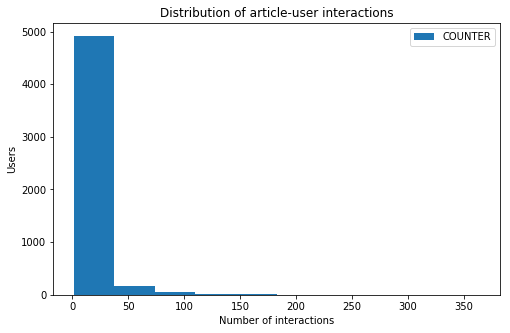

In [22]:
#A  dataframe that will show number of interaction between an article and a user(email)
df['COUNTER'] =1 #counter will count how many times there was an interaction
my_d = df.groupby(['user_id', 'article_id']).count().reset_index()

#A dataframe showing for each user, the total number of article interactions it has made
num_user_i = my_d.groupby('user_id', axis = 0).sum().sort_values(by = ['COUNTER'], ascending = False)

num_user_i[['COUNTER']].plot(kind='hist', figsize=(8, 5))

plt.title('Distribution of article-user interactions') # add a title to the histogram
plt.ylabel('Users') # add y-label
plt.xlabel('Number of interactions') # add x-label

plt.show()

#### To find the median:

In [36]:
num_user_i.shape[0]#Get the shape of this dataframe and see what the middle is

5149

Since this is an odd number, the median should lie in the 2573 th row 

In [23]:
num_user_i[['COUNTER']].iloc[2573,:]#median user, and the number of interactions

COUNTER    3
Name: 2793, dtype: int64

In [24]:
users = num_user_i[['COUNTER']].index#Define what users are

In [26]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364# The maximum number of user-article interactions by any 1 user is ______.

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [27]:
#A dataframe showing for each article, the total number of interactions it has made among all users
my_d = df.groupby(['user_id', 'article_id']).count().reset_index()#.sort_values(by = ['COUNTER'], ascending = False)
num_a = my_d.groupby('article_id', axis = 0).sum().sort_values(by = ['COUNTER'], ascending = False)
num_a[['COUNTER']].head(10)

,COUNTER
article_id,
1429.0,937
1330.0,927
1431.0,671
1427.0,643
1364.0,627
1314.0,614
1293.0,572
1170.0,565
1162.0,512


In [30]:
unique_articles = 714# The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148# The number of unique users
user_article_interactions = 45993# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [31]:
most_viewed_article_id = '1429.0'# The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [32]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [33]:
df.head()

,article_id,title,user_id,COUNTER
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,1
1,1314.0,healthcare python streaming application demo,2,1
2,1429.0,use deep learning for image classification,3,1
3,1338.0,ml optimization using cognitive assistant,4,1
4,1276.0,deploy your python model as a restful api,5,1


In [34]:
def get_top_articles(n, df=df):
    '''
    Produces the topmost popular n article titles from the dataframe df
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    #first group by article_ids and sort from most popular down
    my_d = df.groupby('article_id', axis = 0).count().sort_values(by = ['title'], ascending = False)
    
    #list of top article ids
    top_a = list(my_d['title'].index[:n].values)
    
    #return the article names (titles) using the ids
    top_articles = df[df['article_id'].isin(top_a)]['title'].values
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    Produces the topmost popular n article ids from the dataframe df
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    #group by article ids and sort descending
    my_d = df.groupby('article_id', axis = 0).count().sort_values(by = ['title'], ascending = False)
    
    #return the indices of these articles
    top_a = list(my_d['title'].index[:n].values)
    return top_a # Return the top article ids

In [35]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo'
 'use deep learning for image classification'
 'use deep learning for image classification' ...,
 'insights from new york car accident reports'
 'visualize car data with brunel'
 'insights from new york car accident reports']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [36]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [38]:
# create the user-article matrix with 1's and 0's
def create_user_item_matrix(df):
    '''
    create the user-article matrix with 1's when there is interaction and 0 when there is no interactions
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # A dataframe showing number of interactions for a user-article pair
    dfNew = df.groupby(['user_id', 'article_id']).count().reset_index()
    
    #Create a dataframe with users as rows and articles as columns 
    NewU_A = dfNew.pivot(index = 'user_id', columns = 'article_id')['title']
    
    #a lambda function to track NaN
    apply_1 = lambda x: 1 if not math.isnan(float(x)) else 0
    
    #For each column in NewU_A, apply the above lamda function
    list_col = list(NewU_A.columns)#list of articles
    for i in list_col:
        NewU_A.loc[:,i] = NewU_A.loc[:,i].apply(apply_1)
    
    user_item = NewU_A
    return user_item # return the user_item matrix

user_item = create_user_item_matrix(df)#Use the funtion to create a user-item interaction mtrix

In [9]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
user_item.shape#shape of th matrix

(5149, 714)

In [65]:
#user_item2.shape

In [39]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [40]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    art1 = np.array(user_item.iloc[:,:])
    dot_art = np.dot(art1,np.transpose(art1))
    sim_i = dot_art[user_id-1,:]#Similarity of all users to a given user_id

    # sort by similarity
    i_dict = {}
    for i,j in enumerate(sim_i, start=1):
        i_dict[i] = j
    sorted_i = pd.Series(i_dict).sort_values(ascending = False)#put in a series format

    # create list of just the ids while removing the own user's id
    sorted_list = [i for i in list(sorted_i.index) if i != user_id]
    most_similar_users = sorted_list  
    return most_similar_users # return a list of the users in order from most to least similar

In [41]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


 Above Takes a couple of minutes to run say 5 mins, please be patient

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [42]:
users = list(df['user_id'].unique())#Users

In [43]:
def get_article_names(article_ids, df=df):
    '''
    Get the corresponding article names given the article ids
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = df[df['article_id'].isin(article_ids)]['title'].values
    return set(article_names) # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    Provides a list of the article_ids and article titles that have been seen by a user
    
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    i_seen1 = []
    i_seen2 = [i_seen1.append(str(i)) for i, j in user_item.loc[user_id,:].items() if j == 1]
    article_names = set(get_article_names(i_seen1, df=df))
    article_ids = i_seen1
    return article_ids,article_names# return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    #find the most similar users to the given user id, by way of interactions
    similar_users = find_similar_users(user_id, user_item=user_item)
    seen = get_user_articles(user_id, user_item=user_item)[0]#Article id seen by this user
    
    nrec = 0#initialize number of recommended articles
    
    while nrec < m:
        notseen = []#Initialize list of article id's not yet seen by the user
        for i in similar_users:
            iseen = get_user_articles(i, user_item=user_item)[0]#article_id seen by a given close user i
            diff = set(iseen).difference(seen)#articles in iseen but not in seen
            notseen1 = notseen.extend(diff)#extend a list by the articles in 'diff'
            nrec += len(notseen)#update nrec
            
    recids =  notseen[:m]#Choose arbitrary first m recommendations
    #recs = get_article_names(recids, df=df)
    return recids # return recommendations of article ids for this user_id

test some of the functions and see what the results look like

In [44]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1
#This ran in less than 4 mins

{'airbnb data for analytics: vancouver listings',
 'apache spark lab, part 2: querying data',
 'build a python app on the streaming analytics service',
 'deep learning achievements over the past year ',
 'from spark ml model to online scoring with scala',
 'graph-based machine learning',
 'i am not a data scientist – ibm watson data lab',
 'optimizing a marketing campaign: moving from predictions to actions',
 'spark 2.1 and job monitoring available in dsx',
 'web picks (week of 4 september 2017)'}

In [45]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [82]:
#Finding the most popular users and article interactions

In [46]:
my_d = df.groupby(['user_id', 'article_id']).count().reset_index().sort_values(by = ['COUNTER'], ascending = False)
num_user_i = my_d.groupby('user_id', axis = 0).sum().sort_values(by = ['COUNTER'], ascending = False)
num_user_i[['COUNTER']].head()

,COUNTER
user_id,
23,364
3782,363
98,170
3764,169
203,160


In [47]:
def get_art_int(df, article_id):
    '''
    Obtain the number of interactions a given article id has made across all users
    
    INPUT:
    df - (pandas dataframe) df as defined at the top of the notebook 
    arti_id - the article id you want to find its number of interactions
    
            
    OUTPUT:
    (int) - the cumulatrive number of interactions an article recorded across all users 
     
    '''
    #group by user_id and article_id
    df['COUNTER'] =1
    my_d = df.groupby(['user_id', 'article_id']).count().reset_index().sort_values(by = ['COUNTER'], ascending = False)
    
    #Group by article id and sum interactions per article id
    num_art_i = my_d.groupby('article_id', axis = 0).sum().sort_values(by = ['COUNTER'], ascending = False)
    
    return num_art_i.loc[arti_id,'COUNTER']

def get_user_int(df, user_id):
    '''
    Obtain the number of interactions a given user_id has made across all articles
    
    INPUT:
    user_id - (int) the user id you need its number of interactions with all articles
    df - (pandas dataframe) df as defined at the top of the notebook 
    
            
    OUTPUT:
    cumulative number of interactions (int) of a user across all articles
    '''
    #group by user_id and article_id 
    df['COUNTER'] =1
    my_d = df.groupby(['user_id', 'article_id']).count().reset_index().sort_values(by = ['COUNTER'], ascending = False)
    
    #Group by user id and sum interactions per user id
    num_user_i = my_d.groupby('user_id', axis = 0).sum().sort_values(by = ['COUNTER'], ascending = False)
    
    return num_user_i.loc[user_id,'COUNTER']

def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    sort the a given users's neighboring users by the similarity and then by number of interactions where 
    highest of each is higher in the returned dataframe
    
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - 
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # compute similarity of each user to the provided user
    art1 = np.array(user_item.iloc[:,:])
    dot_art = np.dot(art1,np.transpose(art1))
    sim_i = dot_art[user_id-1,:]#Similarity of each user

    # sort by similarity
    #i_dict = {}#initialise disctionary
    
    #initialize variables
    indexes = []#list to store indices (users_ids)
    simi = []#List of similaritites for each user
    num_int = []#create a list of number of interactions for each user
    
    for i,j in enumerate(sim_i, start=1):
        #num_art = len(get_user_articles(i, user_item=user_item)[0])#Find the number of article interactions
        num_art = get_user_int(df,i)#Find the number of article interactions of user i
        num_int.append(num_art)
        indexes.append(i)
        simi.append(j)
        #i_dict[i] = [j]#get a list of similarity and number of interactions
    
    #create a dataframe with the variables computed
    sorted_i = pd.DataFrame({'user_id': indexes,'similarity': simi,'num_interactions':num_int}).set_index(['user_id'])
    
    #Sort the dataframe by the similarity, and number of interactions
    neighbors_df = sorted_i.sort_values(by = ['similarity','num_interactions'],ascending = False)
    
    # create list of just the ids
    
    #sorted_list = [i for i in list(sorted_i.index) if i != user_id]
    return neighbors_df# Return the dataframe specified in the doc_string

def sort_among(article_ids, df = df):
    '''
    given a set of article ids, sort by the most popular articles
    
    INPUT:
    article_ids - (list) a given list of article ids to sort based on the total num of interactions
    df - (pandas dataframe) df as defined at the top of the notebook 
        
    OUTPUT:
    sorted_article_ids - (list)of article ids sorted based on:
                    num_interactions - the number of times articles were viewed by users
    '''
    
    #Group df by user_id and article id
    df['COUNTER'] =1
    my_d = df.groupby(['user_id', 'article_id']).count().reset_index().sort_values(by = ['COUNTER'], ascending = False)
    
    #sort this group by the article_id and get the sume of number of interactions for each
    num_art = my_d.groupby('article_id', axis = 0).sum().sort_values(by = ['COUNTER'], ascending = False)
    
    #select only the article ids we need
    chosen = num_art[num_art.index.isin(article_ids)]['COUNTER']
    
    #return the article ids in the order of most popular
    sorted_article_ids = list(chosen.index.values)
    return sorted_article_ids

def user_user_recs_part2(user_id, m=10):
    '''
    provide recommendations of articles to a given user_ids applying collaborative filtering
    
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    #top sorted users based on similariy and num_interactions
    similar_users = (get_top_sorted_users(user_id, df=df, user_item=user_item)).index.values
    similar_users = list(similar_users)
    
    seen = get_user_articles(user_id, user_item=user_item)[0]#Article id seen by this user
    
    #Make the m recommndations
    nrec = 0#initialize number of recommendations
    while nrec < m:
        notseen = []
        for i in similar_users:
            iseen = get_user_articles(i, user_item=user_item)[0]#articleid seen by a given close user i
            diff = set(iseen).difference(seen)#articles in iseen but not in seen
            notseen1 = notseen.extend(diff)#extend the recommendations with this 'diff'
            nrec += len(notseen)#update nrec
    
    #return the most popular among the article ids
    n = m-1
    new_id = notseen[n:]
    if nrec > m:
        notseen[n:] = sort_among(new_id, df = df)
        recids = notseen
    else:
        recids = notseen    
    recs =  recids[:m]#The m article ids
    rec_names = set(get_article_names(recs, df=df))
    #return recids and recnames as  recommendations for this user_id
    return recs, rec_names

Below ran in 6 mins please be patient

In [48]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['730.0', '125.0', '1409.0', '981.0', '1357.0', '1424.0', '1176.0', '1386.0', '1335.0', 1429.0]

The top 10 recommendations for user 20 are the following article names:
{'overlapping co-cluster recommendation algorithm (ocular)', 'use spark for python to load data and run sql queries', 'developing for the ibm streaming analytics service', 'labor', 'use deep learning for image classification', 'small steps to tensorflow', 'statistics for hackers', 'super fast string matching in python', 'uci: red wine quality', 'build a python app on the streaming analytics service'}


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [50]:
### Tests with a dictionary of results

user1_most_sim = 3933# Find the user that is most similar to user 1 
user131_10th_sim = 242# Find the 10th most similar user to user 131

In [51]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

##### Given a new user, I will likely recommend the most popular articles to this new user. This is partly because the most popular articles might be the arrticle more highly sought after, and also because this user does not have history of interactions and so I can't tell which type of articles he will like based on his neighbors. Thus, I will use the get_art_int function to obtain the most popular articles, and recommend the top most popular articles to this user.

**Provide your response here.** a better way to make recommendatins to new users would be to use a machinelearning method which
will incorporate some content based recommendations techniques to predict the the articles that this user will like

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [52]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = ['1429.0','1330.0','1431.0','1427.0','1364.0','1314.0','1293.0','1170.0','1162.0','1304.0']# Your recommendation


In [53]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


##### I decided to recommend the most popular articles.

### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [54]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [55]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [56]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

**Provide your response here.** - This is diffeerent than in the lesson because here we have a user_item matrix that simply tells if there is an interaction or if there is not. In the lesson we had a user_item matrix that was a representation of the reviews given to each item by a user. Also, there is no NaN in this user_item matrix, and so we can use the buit in to decompose the matrix.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

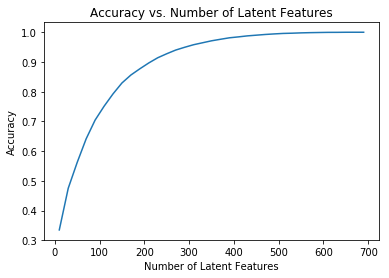

In [57]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - (np.array(sum_errs)/df.shape[0]));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [58]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    creats test and train sets of a user_item matrix fron a given dataframe
    
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    #Using the function 'create_user_item_matrix' to create user_item train annd test
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = list(user_item_test.index)#userss in test set
    test_arts = list(user_item_test.columns)#articles in test set
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [59]:
user_item_train.shape

(4487, 714)

In [60]:
user_item_test.shape

(682, 574)

In [61]:
len(test_arts)

574

In [62]:
#The common users among the train and test user_items
common_user_item_train=user_item_train[user_item_train.index.isin(user_item_test.index)]
common_ids = common_user_item_train.index#common ids in the train and test sets

common_user_item_test = user_item_test[user_item_test.index.isin(common_ids)]#common test set

#The common articles among the train and test user_items
common_arts_ids = user_item_test.columns

In [45]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

KeyError: 'How many movies can we make predictions for in the test set?'

Looks like there is some mistake with the dictionary since it is saying something about movies when I have been working
only with articles

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [63]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [64]:
s_train.shape

(714,)

In [65]:
u_train.shape

(4487, 4487)

In [66]:
vt_train.shape

(714, 714)

In [67]:
common_user_item_test.shape[0]

20

#### TRAIN SET PREDICTIONS

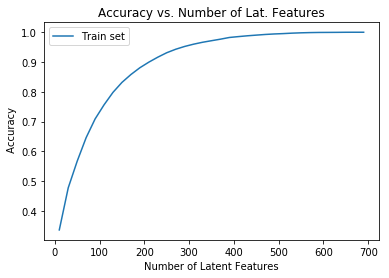

In [68]:
num_latent_feats = np.arange(10,700+10,20)
num_interact = df_train.shape[0]#number of interactions in the training set
#sum_errs = []
sum_errs2 = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # Compute the squared error for each predicted vs. actual rating
    sum_square_errs = np.sum(np.sum((user_item_train - user_item_est)**2))
    sum_errs2.append(sum_square_errs)
    
    # compute error for each prediction to actual value
    #diffs = np.subtract(user_item_train, user_item_est)
    
    # total errors and keep track of them
    #err = np.sum(np.sum(np.abs(diffs)))
    #sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - ((np.array(sum_errs2))/num_interact));
plt.xlabel('Number of Latent Features');
plt.ylabel(' Accuracy');
plt.legend(['Train set'])
plt.title('Accuracy vs. Number of Lat. Features');

#### TEST SET

Compute the matrices of the  test_sets's predictables using the common user ids and common article ids

In [69]:
#Users
user_ids_series = np.array(user_item_train.index)#array of user ids in the train matrix
user_row = np.where(user_ids_series == common_ids[0])[0][0]#Pick the row of first user
u_train_i = np.array([u_train[user_row]])# get the corresponding array from u_train

#find the users's index that exist in both train and and test dataframe
for i in common_ids[1:]:
    user_row = np.where(user_ids_series == i)[0][0]#Pick the row of that user
    arr_i = np.array([u_train[user_row]])#get the corresponding array from u_train
    u_train_i = np.concatenate((u_train_i, arr_i), axis = 0)
    
    
#articles
vt_trans = np.transpose(vt_train)#first transpose the matrix
arts_ids_series = np.array(user_item_train.columns)#array of article ids in the train matrix
arts_row = np.where(arts_ids_series == common_arts_ids[0])[0][0]#Pick the row of first article
vt_train_i = np.array([vt_trans[arts_row]])# get the corresponding array from vt_trans

#find the articles's index that exist in both train and and test dataframe
for i in common_arts_ids[1:]:
    arts_row = np.where(arts_ids_series == i)[0][0]#Pick the row of that article
    arrt_i = np.array([vt_trans[arts_row]])#get the corresponding array from vt_trans
    vt_train_i = np.concatenate((vt_train_i, arrt_i), axis = 0)

#transpose back to get latent features(k) by number of articles (m) matrices
vt_train2 = np.transpose(vt_train_i)

In [72]:
u_train_i.shape

(20, 4487)

In [69]:
vt_train_i.shape

(574, 714)

In [71]:
vt_train2.shape

(714, 574)

Make preedictions on test set's predictables

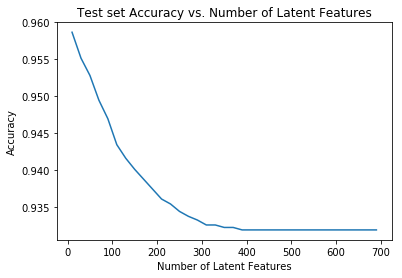

In [70]:
num_latent_feats = np.arange(10,700+10,20)#latent features grid
num_interact = df_test.shape[0]#number of interactions in test set
sum_errs = []
#sum_errs2 = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train_i[:, :k], vt_train2[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # Compute the squared error for each predicted vs. actual rating
    #sum_square_errs = np.sum(np.sum((common_user_item_test - user_item_est)**2))
    #sum_errs2.append(sum_square_errs)
    
    #Or
    
    # compute error for each prediction to actual value
    diffs = np.subtract(common_user_item_test, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - (np.array(sum_errs)/num_interact));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Test set Accuracy vs. Number of Latent Features');

#### All Errors

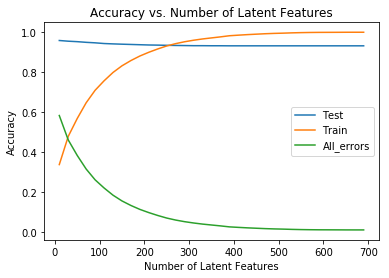

In [71]:
#Combine both erros from train and test set to see what the plt with latent features look like
#sum_errs is for the test set while sum_errs2 is for the train set

my_err = []#initialize the combined error list
for i in range(len(sum_errs)):
    rr = sum_errs2[i]+sum_errs[i]
    my_err.append(rr)

#compute accuracies and combine into dataframe
my_err = np.array(my_err)/df.shape[0]#all errors
sum_errs = np.array(sum_errs)/df_test.shape[0]#test set's errors
sum_errs2 = np.array(sum_errs2)/df_train.shape[0]#train set's errors
combined = pd.DataFrame({'Features':num_latent_feats, 'Test':1-(sum_errs), 'Train': 1-(sum_errs2), 'All_errors':my_err})
combined.set_index('Features', inplace = True)#set index to be the latent features

#Visualize the error/accuracies
combined.plot(kind = 'line' );
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [72]:
combined.head()

,Test,Train,All_errors
Features,,,
10,0.958618,0.336450,0.582480
30,0.955114,0.477850,0.459961
50,0.952778,0.567200,0.382558
70,0.949441,0.646275,0.314222
90,0.946938,0.708950,0.260040


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**- The above plots show that as you increase the number of latent features for the train set, you get better with predictions. But for the test set, as you increase the number of latent feature, your accuracy reduces. This is intriguing but I will infer that because the accruacy of the train sets is so high - almost 1 for high number of latent feature, I will reduce this, to avoid over fitting. More still, I will seek more datasets to help avoid this.

In order to know if my recommendations with the systems I have designed thusfar are an improvement to current methods
of finding articles on the IBM watson platform, I will design an experiment that will measure the satisfaction (by way of ratings) of users on the platform using any of my recomendation systems. This could involve having the users give a rating of the recommendations given to them. By using SVD and/or FUNK-SVD, I can measure the performance of my recommendation systems.

Also, since new users will most likely not have a control experiemnet, I will simply recommend the most popular articles to them and also have these new users give their rating(satisfaction). From the results, I can tell if my system is giving good recommendations.

In [73]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0